In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: Venn diagram
try:
    from matplotlib_venn import venn2
except ImportError:
    print("matplotlib-venn not installed. Install with: pip install matplotlib-venn")

# Base paths (relative to notebooks/)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "combined_features.csv"
MPD_DIR = DATA_RAW / "mpd"

print("Features CSV:", FEATURES_PATH)
print("MPD dir:", MPD_DIR)


Features CSV: C:\Users\Kiera\Music_Recommender\data\processed\combined_features.csv
MPD dir: C:\Users\Kiera\Music_Recommender\data\raw\mpd


In [2]:
# Load combined features
features_df = pd.read_csv(FEATURES_PATH)

print("combined_features.csv shape:", features_df.shape)
print("Columns:", list(features_df.columns))

features_df.head()


combined_features.csv shape: (4589288, 17)
Columns: ['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'year', 'explicit', 'time_signature', 'popularity']


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
0,0000QuApNltQzqS5ROXcQ7,0.629,0.199,4,-15.258,1,0.0610,0.9250,0.000000,0.1100,0.587,66.469,141813.0,2012.0,NaN,4.0,NaN
1,0000j9zugybaOxAeENtFRU,0.680,0.378,5,-7.379,1,0.0685,0.8850,0.000013,0.1200,0.963,116.877,112107.0,NaN,NaN,4.0,NaN
2,0000korRHja9p9XaR5UA5m,0.708,0.714,6,-7.579,1,0.0362,0.3970,0.000047,0.3540,0.756,120.538,235666.0,1995.0,NaN,4.0,NaN
3,0000uJA4xCdxThagdLkkLR,0.458,0.591,5,-5.621,1,0.0326,0.5680,0.000015,0.2860,0.654,184.913,161187.0,NaN,NaN,3.0,NaN
4,00018DRtkxXS7SmAG4ciN6,0.456,0.324,8,-11.521,1,0.0342,0.0242,0.596000,0.0868,0.522,184.970,238827.0,NaN,NaN,3.0,NaN


In [3]:
# We assume track_id is the column holding Spotify IDs
if "track_id" not in features_df.columns:
    raise KeyError("Expected 'track_id' column in combined_features.csv")

feature_track_ids = set(features_df["track_id"].dropna().astype(str))

print(f"Unique track_ids in combined_features: {len(feature_track_ids):,}")


Unique track_ids in combined_features: 4,589,288


In [4]:
def extract_track_id_from_uri(uri: str) -> str | None:
    """
    Convert 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI' → '0UaMYEvWZi0ZqiDOoHU3YI'.
    """
    if not isinstance(uri, str):
        return None
    parts = uri.split(":")
    return parts[-1] if len(parts) >= 3 else None

# Find all MPD slice JSON files (recursively, in case they’re under mpd/data/)
mpd_files = sorted(MPD_DIR.rglob("mpd.slice.*.json"))
print(f"Found {len(mpd_files)} MPD slice files")

mpd_track_ids = set()
total_playlists = 0
total_track_entries = 0

for path in mpd_files:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    playlists = data.get("playlists", [])
    total_playlists += len(playlists)

    for pl in playlists:
        tracks = pl.get("tracks", [])
        total_track_entries += len(tracks)
        for t in tracks:
            uri = t.get("track_uri")
            tid = extract_track_id_from_uri(uri)
            if tid:
                mpd_track_ids.add(tid)

print("\n=== MPD Stats ===")
print(f"Total playlists in these slices:          {total_playlists:,}")
print(f"Total track entries (with duplicates):    {total_track_entries:,}")
print(f"Unique track IDs in MPD (from slices):    {len(mpd_track_ids):,}")


Found 100 MPD slice files

=== MPD Stats ===
Total playlists in these slices:          100,000
Total track entries (with duplicates):    6,685,101
Unique track IDs in MPD (from slices):    679,889


In [5]:
# Intersection
intersection_ids = feature_track_ids & mpd_track_ids

n_feat = len(feature_track_ids)
n_mpd = len(mpd_track_ids)
n_intersection = len(intersection_ids)

print("=== Overlap Summary ===")
print(f"Unique track IDs in combined_features:      {n_feat:,}")
print(f"Unique track IDs in MPD:                    {n_mpd:,}")
print(f"Overlap (tracks present in BOTH):           {n_intersection:,}")
print(f"  - % of MPD covered by features:           {n_intersection / n_mpd * 100:.2f}%")
print(f"  - % of features that appear in MPD:       {n_intersection / n_feat * 100:.2f}%")

# Build a small summary table
summary_rows = [
    {
        "set": "combined_features only",
        "count": n_feat - n_intersection,
        "pct_of_features": (n_feat - n_intersection) / n_feat * 100,
        "pct_of_mpd": 0.0,
    },
    {
        "set": "MPD only",
        "count": n_mpd - n_intersection,
        "pct_of_features": 0.0,
        "pct_of_mpd": (n_mpd - n_intersection) / n_mpd * 100,
    },
    {
        "set": "Intersection (both)",
        "count": n_intersection,
        "pct_of_features": n_intersection / n_feat * 100,
        "pct_of_mpd": n_intersection / n_mpd * 100,
    },
]

overlap_df = pd.DataFrame(summary_rows)
print("\n=== Overlap Table ===")
display(overlap_df)


=== Overlap Summary ===
Unique track IDs in combined_features:      4,589,288
Unique track IDs in MPD:                    679,889
Overlap (tracks present in BOTH):           514,672
  - % of MPD covered by features:           75.70%
  - % of features that appear in MPD:       11.21%

=== Overlap Table ===


,set,count,pct_of_features,pct_of_mpd
0,combined_features only,4074616,88.785363,0.000000
1,MPD only,165217,0.000000,24.300584
2,Intersection (both),514672,11.214637,75.699416


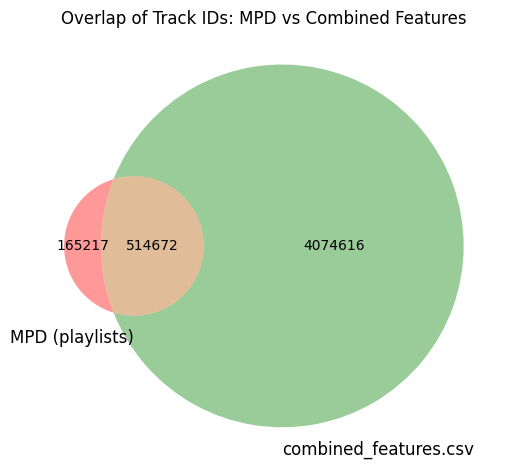

In [6]:
if "venn2" not in globals():
    try:
        from matplotlib_venn import venn2
    except Exception as e:
        print("Could not import matplotlib_venn. Install it with:")
        print("  pip install matplotlib-venn")
        raise e

plt.figure(figsize=(6, 6))
venn2(
    subsets=(
        n_mpd - n_intersection,      # MPD only
        n_feat - n_intersection,     # Features only
        n_intersection               # Both
    ),
    set_labels=("MPD (playlists)", "combined_features.csv")
)
plt.title("Overlap of Track IDs: MPD vs Combined Features")
plt.show()


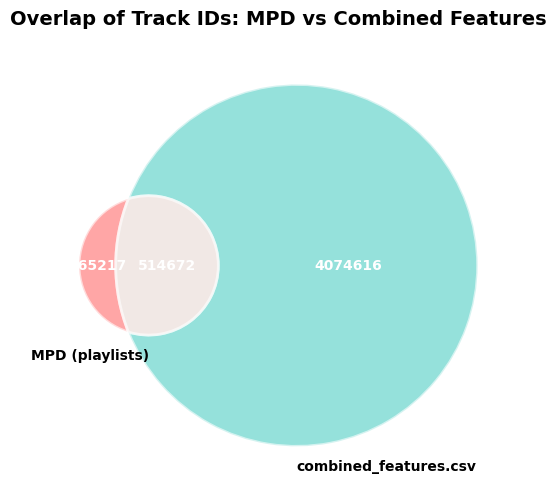

In [18]:
if "venn2" not in globals():
    try:
        from matplotlib_venn import venn2
    except Exception as e:
        print("Could not import matplotlib_venn. Install it with:")
        print("  pip install matplotlib-venn")
        raise e

# Color options - feel free to change these!
color_mpd = '#FF6B6B'           # Coral Red for MPD
color_features = '#4ECDC4'      # Turquoise for Features
alpha_value = 0.6               # Transparency (0-1)
edge_color = 'white'            # Border color
edge_width = 2                  # Border thickness

plt.figure(figsize=(12, 5))  # Wider figure
ax = plt.subplot(111)

v = venn2(
    subsets=(
        n_mpd - n_intersection,      # MPD only
        n_feat - n_intersection,     # Features only
        n_intersection               # Both
    ),
    set_labels=("MPD (playlists)", "combined_features.csv"),
    set_colors=(color_mpd, color_features),
    alpha=alpha_value,
    ax=ax
)

# Set aspect ratio to keep circles circular
ax.set_aspect('equal')

# Customize the patches (circles)
for patch in v.patches:
    if patch:
        patch.set_edgecolor(edge_color)
        patch.set_linewidth(edge_width)

# Customize text styling
for text in v.set_labels:
    if text:
        text.set_fontsize(10)
        text.set_fontweight('bold')

for text in v.subset_labels:
    if text:
        text.set_fontsize(10)
        text.set_fontweight('bold')
        text.set_color('white')

plt.title("Overlap of Track IDs: MPD vs Combined Features", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

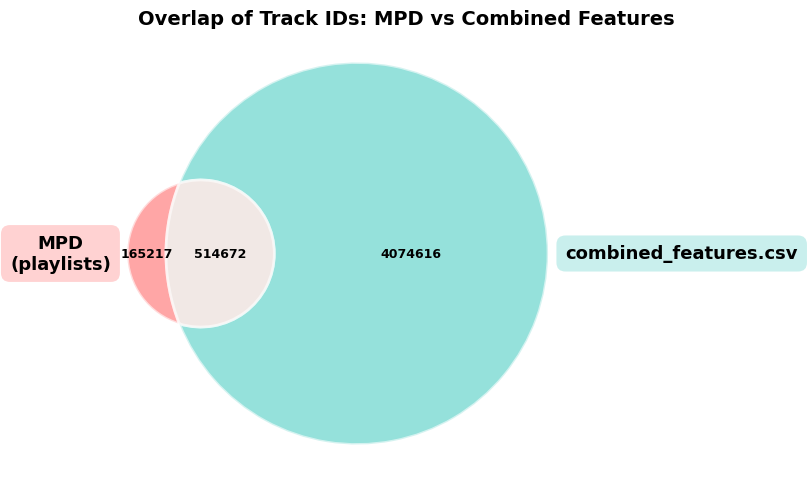

In [36]:
if "venn2" not in globals():
    try:
        from matplotlib_venn import venn2
    except Exception as e:
        print("Could not import matplotlib_venn. Install it with:")
        print("  pip install matplotlib-venn")
        raise e

# Color options - feel free to change these!
color_mpd = '#FF6B6B'           # Coral Red for MPD
color_features = '#4ECDC4'      # Turquoise for Features
alpha_value = 0.6               # Transparency (0-1)
edge_color = 'white'            # Border color
edge_width = 2                  # Border thickness
title_shift = 0.14              # Adjust this to shift title left/right (negative = left, positive = right)

plt.figure(figsize=(14, 5))  # Even wider figure
ax = plt.subplot(111)

v = venn2(
    subsets=(
        n_mpd - n_intersection,      # MPD only
        n_feat - n_intersection,     # Features only
        n_intersection               # Both
    ),
    set_labels=("", ""),  # Remove default labels
    set_colors=(color_mpd, color_features),
    alpha=alpha_value,
    ax=ax
)

# Set aspect ratio to keep circles circular
ax.set_aspect('equal')

# Customize the patches (circles)
for patch in v.patches:
    if patch:
        patch.set_edgecolor(edge_color)
        patch.set_linewidth(edge_width)

# Customize subset labels (numbers)
for text in v.subset_labels:
    if text:
        text.set_fontsize(9)
        text.set_fontweight('bold')
        text.set_color('black')

# Add custom labels on the left and right sides
# Get the center positions of the circles
left_circle_x = v.get_label_by_id('10').get_position()[0] if v.get_label_by_id('10') else -0.5
right_circle_x = v.get_label_by_id('01').get_position()[0] if v.get_label_by_id('01') else 0.5

# Place labels further to the left and right
ax.text(left_circle_x - 0.25, 0, "MPD\n(playlists)", 
        fontsize=13, fontweight='bold', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor=color_mpd, alpha=0.3, edgecolor='none'))

ax.text(right_circle_x + 0.785, 0, "combined_features.csv", 
        fontsize=13, fontweight='bold', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor=color_features, alpha=0.3, edgecolor='none'))

# Add title with horizontal shift
plt.title("Overlap of Track IDs: MPD vs Combined Features", 
          fontsize=14, fontweight='bold', pad=0, x=0.5 + title_shift)
plt.tight_layout()
plt.show()

In [7]:
# Take a small sample of overlapping IDs
sample_ids = list(intersection_ids)
if len(sample_ids) > 20:
    sample_ids = np.random.choice(sample_ids, size=20, replace=False)

sample_ids = list(sample_ids)

# Look these up in features_df (if you later add names/metadata there)
overlap_features_sample = features_df[features_df["track_id"].isin(sample_ids)]

print("Sample of overlapping tracks from combined_features:")
display(overlap_features_sample.head(20))


Sample of overlapping tracks from combined_features:


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
121221,0BxwLWELYVGKqzUGXJNmT7,0.522,0.8450,0,-1.828,1,0.0345,0.00140,0.359000,0.0922,0.7280,158.965,249706.0,2015.0,NaN,4.0,45.0
1002495,1engDQ0FsRAQMxWTb2n8wP,0.567,0.7790,2,-6.558,1,0.0276,0.03840,0.012100,0.1750,0.4810,137.985,220027.0,NaN,NaN,4.0,NaN
1120058,1r1YYR98PlMe2FyMtH5EHv,0.483,0.8590,4,-5.447,0,0.2700,0.38700,0.000011,0.1100,0.8350,173.848,220604.0,NaN,NaN,4.0,NaN
1364798,2GhGgze219mIHu7ZNkgThG,0.490,0.6220,7,-6.234,1,0.0250,0.10200,0.000119,0.1830,0.2940,104.848,288360.0,2011.0,False,4.0,NaN
1968514,3IDQ9pWoZFhuKLomKEao8F,0.867,0.5440,4,-6.778,1,0.0556,0.12000,0.000014,0.1040,0.7600,110.083,170493.0,NaN,NaN,4.0,NaN
2036553,3PRXN5DHTUtODlKpFokRTZ,0.686,0.6670,10,-6.771,0,0.1040,0.23600,0.000000,0.1680,0.6110,95.952,193067.0,NaN,NaN,4.0,NaN
2097563,3Vtgng4bH7j2HSO8HObci9,0.641,0.9770,6,-4.487,0,0.1240,0.08540,0.000000,0.4370,0.3130,107.038,146046.0,2016.0,NaN,4.0,48.0
2302102,3rWBerJZHd5IvS6o3dQEk7,0.595,0.5070,0,-7.152,1,0.0363,0.27000,0.000000,0.0376,0.7070,134.189,229587.0,2009.0,0,4.0,55.0
2544449,4HCO4dPnJDaBdaEzqwCJdP,0.461,0.8080,5,-4.240,0,0.0588,0.35200,0.000000,0.1240,0.9430,84.084,215160.0,NaN,NaN,4.0,NaN
2547770,4HY0r40I8XhNXYTu94OWdq,0.668,0.8900,0,-6.424,0,0.0419,0.00394,0.006050,0.2330,0.8710,159.947,188747.0,NaN,NaN,4.0,NaN


In [8]:
features_track_ids = set(features_df["track_id"].astype(str))
intersection_ids = features_track_ids & mpd_track_ids

print("=== Overlap Summary ===")
print(f"Unique track IDs in combined_features: {len(features_track_ids):,}")
print(f"Unique track IDs in MPD:               {len(mpd_track_ids):,}")
print(f"Overlap (tracks present in BOTH):      {len(intersection_ids):,}")
print(f"  - % of MPD covered by features:      {len(intersection_ids) / len(mpd_track_ids) * 100:.2f}%")
print(f"  - % of features in MPD:              {len(intersection_ids) / len(features_track_ids) * 100:.2f}%")

# Filter features_df down to only overlapping track_ids
merged_df = features_df[features_df["track_id"].astype(str).isin(intersection_ids)].copy()

print("\nmerged_df shape (features only for tracks that appear in MPD):", merged_df.shape)
merged_df.head()


=== Overlap Summary ===
Unique track IDs in combined_features: 4,589,288
Unique track IDs in MPD:               679,889
Overlap (tracks present in BOTH):      514,672
  - % of MPD covered by features:      75.70%
  - % of features in MPD:              11.21%

merged_df shape (features only for tracks that appear in MPD): (514672, 17)


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
3,0000uJA4xCdxThagdLkkLR,0.458,0.5910,5,-5.621,1,0.0326,0.5680,0.000015,0.286,0.654,184.913,161187.0,NaN,NaN,3.0,NaN
8,00039MgrmLoIzSpuYKurn9,0.742,0.7530,1,-5.632,1,0.0364,0.0178,0.000000,0.133,0.263,132.064,222727.0,NaN,NaN,4.0,NaN
14,0005w1bMJ7QAMl6DY98oxa,0.253,0.1970,6,-17.695,1,0.0461,0.8830,0.005620,0.152,0.377,61.556,111573.0,NaN,NaN,4.0,NaN
56,000JBgYWfJQqdFaRqu2n3f,0.496,0.0481,7,-26.668,0,0.0520,0.9790,0.767000,0.110,0.125,79.477,227627.0,NaN,NaN,4.0,NaN
57,000JCyEkMFumqCZQJAORiQ,0.795,0.8740,0,-4.523,1,0.2100,0.0646,0.000000,0.341,0.483,132.966,207125.0,NaN,NaN,4.0,NaN


In [9]:
cols_of_interest = ["explicit", "popularity", "year", "time_signature", "duration_ms"]

missing_summary_rows = []
n_rows = len(merged_df)

for col in cols_of_interest:
    if col not in merged_df.columns:
        continue

    missing_count = merged_df[col].isna().sum()
    missing_pct = missing_count / n_rows * 100

    # For numeric cols, we can also count zeros
    if pd.api.types.is_numeric_dtype(merged_df[col]):
        zero_count = (merged_df[col] == 0).sum()
        zero_pct = zero_count / n_rows * 100
    else:
        zero_count = np.nan
        zero_pct = np.nan

    missing_summary_rows.append({
        "feature": col,
        "dtype": str(merged_df[col].dtype),
        "n_rows": n_rows,
        "missing_count": missing_count,
        "missing_pct": round(missing_pct, 3),
        "zero_count": zero_count,
        "zero_pct": round(zero_pct, 3) if pd.notna(zero_pct) else np.nan,
    })

missing_overlap_df = pd.DataFrame(missing_summary_rows)
print("=== Missing / Zero Summary for Key Columns (in MPD ∩ features subset) ===")
missing_overlap_df


=== Missing / Zero Summary for Key Columns (in MPD ∩ features subset) ===


,feature,dtype,n_rows,missing_count,missing_pct,zero_count,zero_pct
0,explicit,object,514672,402942,78.291,NaN,NaN
1,popularity,float64,514672,364657,70.852,180.0,0.035
2,year,float64,514672,353033,68.594,0.0,0.000
3,time_signature,float64,514672,1615,0.314,428.0,0.083
4,duration_ms,float64,514672,6016,1.169,0.0,0.000


In [10]:
numeric_cols = [
    c for c in merged_df.columns
    if c != "track_id" and pd.api.types.is_numeric_dtype(merged_df[c])
]

rows = []
n_rows = len(merged_df)

for col in numeric_cols:
    missing_count = merged_df[col].isna().sum()
    missing_pct = missing_count / n_rows * 100

    zero_count = (merged_df[col] == 0).sum()
    zero_pct = zero_count / n_rows * 100

    rows.append({
        "feature": col,
        "dtype": str(merged_df[col].dtype),
        "n_rows": n_rows,
        "missing_count": missing_count,
        "missing_pct": round(missing_pct, 3),
        "zero_count": zero_count,
        "zero_pct": round(zero_pct, 3),
        "valid_nonzero_count": n_rows - missing_count - zero_count,
    })

coverage_overlap_df = (
    pd.DataFrame(rows)
    .sort_values(by=["missing_pct", "zero_pct"], ascending=[False, False])
    .reset_index(drop=True)
)

print("=== Missing / Zero Summary for ALL numeric features (only overlap rows) ===")
coverage_overlap_df


=== Missing / Zero Summary for ALL numeric features (only overlap rows) ===


,feature,dtype,n_rows,missing_count,missing_pct,zero_count,zero_pct,valid_nonzero_count
0,popularity,float64,514672,364657,70.852,180,0.035,149835
1,year,float64,514672,353033,68.594,0,0.000,161639
2,duration_ms,float64,514672,6016,1.169,0,0.000,508656
3,time_signature,float64,514672,1615,0.314,428,0.083,512629
4,mode,int64,514672,0,0.000,175661,34.131,339011
5,instrumentalness,float64,514672,0,0.000,155617,30.236,359055
6,key,int64,514672,0,0.000,61512,11.952,453160
7,valence,float64,514672,0,0.000,521,0.101,514151
8,danceability,float64,514672,0,0.000,417,0.081,514255
9,speechiness,float64,514672,0,0.000,417,0.081,514255


In [11]:
def missing_stats(df, cols):
    rows = []
    n = len(df)
    for col in cols:
        if col not in df.columns:
            continue
        mc = df[col].isna().sum()
        mp = mc / n * 100
        rows.append({
            "feature": col,
            "n_rows": n,
            "missing_count": mc,
            "missing_pct": round(mp, 3),
        })
    return pd.DataFrame(rows)

original_missing = missing_stats(features_df, cols_of_interest)
overlap_missing = missing_stats(merged_df, cols_of_interest)

original_missing["scope"] = "all_features"
overlap_missing["scope"] = "overlap_only"

compare_missing = pd.concat([original_missing, overlap_missing], ignore_index=True)
compare_missing = compare_missing.pivot(index="feature", columns="scope", values="missing_pct")

print("=== Missing % in original vs overlap-only ===")
compare_missing


=== Missing % in original vs overlap-only ===


scope,all_features,overlap_only
feature,,
duration_ms,0.131,1.169
explicit,60.792,78.291
popularity,59.542,70.852
time_signature,0.478,0.314
year,46.512,68.594
